In [1]:
# !pip install tensorflow-addons
# !pip install numpy
# !pip install tensorflow
# !pip install pillow
# !pip install scipy
# !pip install matplotlib

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
import tensorflow as tf

# Get the list of physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
# Check if there are GPUs available
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Explicitly allow memory growth
        tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_dir = "D:\saaswath\projects\plant disease and recommandation\plant\PlantVillage"

In [5]:
from keras.preprocessing.image import ImageDataGenerator


img_dataset = ImageDataGenerator(
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 360)
    width_shift_range=.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    validation_split=0.3
    )
img_train = img_dataset.flow_from_directory(batch_size=64, directory=train_dir,target_size=(224,224),subset="training",color_mode="rgb", shuffle=False)

#print(img_dataset.class_indices)

img_test = img_dataset.flow_from_directory(batch_size=64, directory=train_dir,target_size=(224,224),subset="validation",color_mode='rgb', shuffle=False)


Found 7200 images belonging to 15 classes.
Found 3077 images belonging to 15 classes.


In [6]:

trainclasses = img_train.class_indices
resultmap={}
for faceValue,faceName in zip(trainclasses.values(),trainclasses.keys()):
  resultmap[faceValue]=faceName

import pickle
with open("resultmap.pkl",'wb') as file:
  pickle.dump(resultmap,file)

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 50  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [8]:
# Initialize an empty list to store batches
all_batches = []

# Number of batches to loop over
num_batches = 64

# Loop through all batches
for i in range(num_batches):
    # Get the next batch
    x_batch, y_batch = next(img_train)
    
    # Append the batch to the list
    all_batches.append((x_batch, y_batch))

# Concatenate all batches along the batch axis
x_train = np.concatenate([batch[0] for batch in all_batches])
y_train = np.concatenate([batch[1] for batch in all_batches])

# Print the shape of the concatenated dataset
print(x_train.shape, y_train.shape)


(4096, 224, 224, 3) (4096, 15)


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images, sizes=[1,self.patch_size,self.patch_size,1],strides=[1, patch_size, patch_size, 1],
    rates=[1, 1, 1, 1],
    padding='VALID')
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


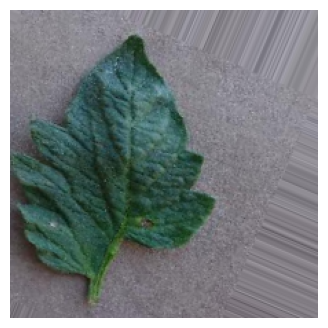

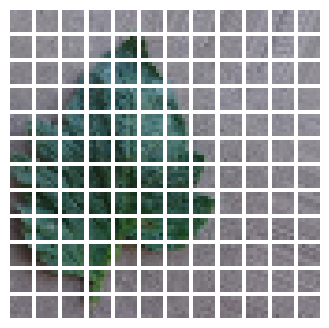

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow((patch_img.numpy()).astype("uint8"))
    plt.axis("off")

In [16]:
recomdation = {
    "Pepper__bell___Bacterial_spot":"""Copper sprays can be used to control bacterial leaf spot, but they are not as effective when used alone on a continuous basis. Thus, combining these sprays with a plant resistance inducer, such as Regalia or Actigard, can provide good protection from the disease.""",
    "Pepper__bell___healthy":"""Bell peppers (Capsicum annuum) are fruits that belong to the nightshade family. They are low in calories and rich in vitamin C and other antioxidants, making them an excellent addition to a healthy diet """,
    "Potato___Early_blight":"""Prune or stake plants to improve air circulation and reduce fungal problems.
Make sure to disinfect your pruning shears (one part bleach to 4 parts water) after each cut.
Keep the soil under plants clean and free of garden debris. Add a layer of organic compost to prevent the spores from splashing back up onto vegetation.
Drip irrigation and soaker hoses can be used to help keep the foliage dry.
For best control, apply copper-based fungicides early, two weeks before disease normally appears or when weather forecasts predict a long period of wet weather. Alternatively, begin treatment when disease first appears, and repeat every 7-10 days for as long as needed.""",
    "Potato___healthy":"""
""",
"Potato___Late_blight": """Varieties resistant to this disease are available. In general, late maturing varieties are more resistant than the earlier maturing varieties. Keep plants healthy; stressed plants are more predisposed to early blight. Avoid overhead irrigation. Do not dig tubers until they are fully mature in order to prevent damage. Do not use a field for potatoes that was used for potatoes or tomatoes the previous year. Keep this year’s field at least 225 to 450 yards away from last year’s field. Surround the field with wheat to keep wind-blown spores from entering. Use adequate nitrogen levels and low phosphorus levels to reduce disease severity. See current recommendations for chemical control measures.""",
"Tomato___Bacterial_spot":"""Use copper fungicides, or copper plus mancozeb. It is very important to have healthy seedlings free from bacterial spot, so spraying should start in the nursery, and continue at 7-10 day intervals in the field. Spraying early, when the plants are young, is especially important as in wet, windy weather, sprays alone often fail to give adequate control.""",

"Tomato_Target_Spot" : "Regular application of fungicides is a primary strategy. Applications should begin before symptoms appear when conditions are favorable for infection and disease development",

"Tomato_Tomato_mosic_virus":"The virus may be introduced on infected seed. Only a small number of seedlings need to be infected for the virus to spread rapidly.It can also be spread on contaminated tools and the clothing and hands of workers during routine activities.",

"Tomato_Tomato_YellowLeaf__Curl_Virus":"""
symptomatic plants should be carefully covered by a clear or black plastic bag and tied at the stem at soil line. Cut off the plant below the bag and allow bag with plant and whiteflies to desiccate to death on the soil surface for 1-2 days prior to placing the plant in the trash. Do not cut the plant off or pull it out of the garden and toss it on the compost! The goal is to remove the plant reservoir of virus from the garden and to trap the existing virus-bearing whiteflies so they do not disperse onto other tomatoes.
""",
"Tomato_Bacterial_Spot": """
 Soak seeds in 10% water solution of household bleach (5.25% sodium hypochlorite) for 45 min, and rinse thoroughly.
""",
"Tomato_Early_blight":"",
"Tomato_Late_blight":"",
"Tomato_Septoria_leaf_spot":"",
"Tomato_Spider_mites_Two_spotted_spider_mite":"Early detection of mite populations is important since initial spider mite infestations can be spotty/localized. Frequent scouting, especially during hot, dry conditions, is recommended. Initially, scouting should be focused on the borders of vegetable fields",
"Tomato_Leaf_Mold":""

    
}
import pickle
with open("recommdationmap.pkl",'wb') as file:
  pickle.dump(recomdation,file)

In [7]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [8]:
input_shape = (224,224,3)
num_classes = 15


In [9]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes,"softmax")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [17]:
y_train.shape

(4096, 15)

In [18]:
def run_experiment(model):
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./model/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )



    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)



Epoch 1/50


c:\Users\saaswath\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


103/103 [==============================] - 53s 385ms/step - loss: 3.1544 - accuracy: 0.3248 - top-5-accuracy: 0.8379 - val_loss: 4.1109 - val_accuracy: 0.0317 - val_top-5-accuracy: 0.3671
Epoch 2/50
103/103 [==============================] - 37s 361ms/step - loss: 1.5485 - accuracy: 0.4670 - top-5-accuracy: 0.9307 - val_loss: 5.1187 - val_accuracy: 0.1695 - val_top-5-accuracy: 0.3634
Epoch 3/50
103/103 [==============================] - 37s 356ms/step - loss: 1.2197 - accuracy: 0.5821 - top-5-accuracy: 0.9649 - val_loss: 8.3919 - val_accuracy: 0.1378 - val_top-5-accuracy: 0.4354
Epoch 4/50
103/103 [==============================] - 33s 322ms/step - loss: 1.0866 - accuracy: 0.6386 - top-5-accuracy: 0.9774 - val_loss: 7.5596 - val_accuracy: 0.1732 - val_top-5-accuracy: 0.4963
Epoch 5/50
103/103 [==============================] - 33s 324ms/step - loss: 0.8927 - accuracy: 0.7097 - top-5-accuracy: 0.9866 - val_loss: 7.8747 - val_accuracy: 0.1378 - val_top-5-accuracy: 0.4732
Epoch 6/50
103/1

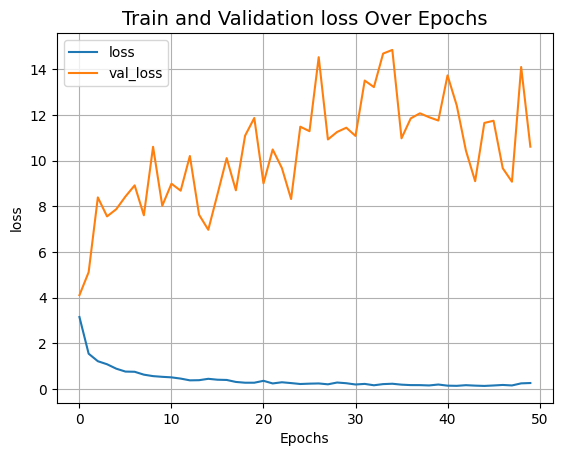

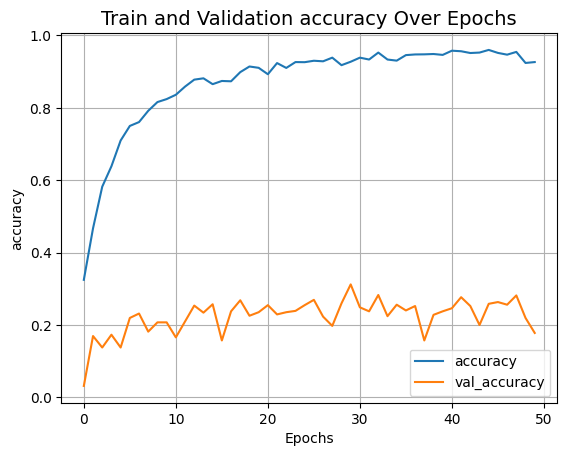

In [19]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [10]:
vision_transformer = create_vit_classifier()
vision_transformer.load_weights("./model/checkpoint.weights.h5")

In [11]:
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 224, 224

# load the image
img = tf.keras.utils.load_img(r'D:\saaswath\projects\plant disease and recommandation\plant\PlantVillage\Potato___healthy\046641c1-f837-49eb-b5f2-4109910a027c___RS_HL 1878.JPG', target_size = (img_width, img_height))

# convert the image to a numpy array
img = tf.keras.utils.img_to_array(img)

# expand dimensions so the model can accept the image as input
img = np.expand_dims(img, axis = 0)

# make the prediction
prediction = vision_transformer.predict(img)


1/1 [==============================] - 2s 2s/step


In [17]:
with open('resultmap.pkl','rb') as f:
    resultmap = pickle.load(f)

In [12]:
prediction

array([[1.36320868e-05, 2.64399638e-03, 3.05082857e-08, 3.22489504e-05,
        9.97293055e-01, 1.62683791e-05, 6.56206112e-07, 8.14078831e-08,
        3.83935259e-16, 1.10564024e-13, 1.95246346e-15, 3.76025750e-15,
        2.55816634e-15, 7.33794552e-15, 1.70969704e-14]], dtype=float32)

In [18]:
final_pred = np.argmax(prediction)
# resultmap[final_pred]
img_reshape = np.reshape(img,(224,672))
# plt.imshow(img_reshape)
print("Disease Type:",resultmap[final_pred])
print("Recomdation:",recomdation[resultmap[final_pred]])

Disease Type: Potato___healthy
Recomdation: 



In [25]:
x_test,y_test = next(img_test)

In [26]:
final_prediction = vision_transformer.predict(x_test)

2/2 [==============================] - 0s 53ms/step


In [27]:
final_prediction.shape

(64, 15)

In [28]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
from sklearn.metrics import classification_report


report = classification_report(np.argmax(y_test,axis=1),np.argmax(final_prediction,axis=1))

c:\Users\saaswath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saaswath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\saaswath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [30]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        64
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.86        64
   macro avg       0.25      0.21      0.23        64
weighted avg       1.00      0.86      0.92        64

